<a href="https://colab.research.google.com/github/Garvit-Pahwa-03/Hydration-Status-Prediction-Model/blob/main/Runverve_Task_R2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.6 MB/s eta 0:00:00


#Importing Libraries


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

#Synthetic Data Generation
We'll generate synthetic data that mimics physiological and environmental factors influencing hydration.<br>
Features:<br>
`HeartRate (bpm)`: Normal 60-100. Increases with dehydration.<br>
`BodyTemperature (°C)`: Normal 36.5-37.5. Can increase.<br>
`AmbientTemperature (°C)`: E.g., 15-40.<br>
`ActivityLevel (0-10)`: 0 (rest) to 10 (intense exercise).<br>
`FluidIntake_LastHour (mL)`: E.g., 0-1000 mL.<br>
`TimeSinceLastDrink (hours)`: E.g., 0-5 hours.<br>
Target:<br>
`HydrationStatus`: 0 (Well Hydrated), 1 (Mildly Dehydrated), 2 (Dehydrated)<br>


In [3]:
def generate_synthetic_data(num_samples=2000):
    data = []
    for _ in range(num_samples):
        # Baseline features
        hr = np.random.uniform(55, 85) # Resting activity base
        body_temp = np.random.uniform(36.5, 37.2)
        ambient_temp = np.random.uniform(15, 35)
        activity_level = np.random.uniform(0, 10)
        fluid_intake_lh = np.random.uniform(0, 750) # mL in last hour
        time_since_drink = np.random.uniform(0, 4)

        # Simulate effects leading to dehydration
        dehydration_score = 0

        # Higher activity, ambient temp, time since drink increase score
        dehydration_score += (activity_level / 2) # Max +5
        dehydration_score += ((ambient_temp - 20) / 5) if ambient_temp > 20 else 0 # Max +3 if ambient is 35
        dehydration_score += time_since_drink * 1.5 # Max +6

        # Higher fluid intake decreases score
        dehydration_score -= (fluid_intake_lh / 150) # Max -5 if 750ml

        # Adjust HR and Body Temp based on score (simplified)
        if dehydration_score > 3: # Mildly dehydrated or worse
            hr += dehydration_score * np.random.uniform(2, 5) # HR increases
            body_temp += dehydration_score * np.random.uniform(0.05, 0.1)
        if dehydration_score > 6: # Dehydrated
            hr += dehydration_score * np.random.uniform(1, 3) # Further HR increase
            body_temp += dehydration_score * np.random.uniform(0.03, 0.08)

        # Cap HR and Body Temp to realistic values
        hr = min(hr, 180)
        body_temp = min(body_temp, 39.5)

        # Determine Hydration Status based on score
        if dehydration_score < 2.5: # Factors suggest good hydration
            status = 0 # Well Hydrated
        elif dehydration_score < 5.5:
            status = 1 # Mildly Dehydrated
        else:
            status = 2 # Dehydrated

        data.append([hr, body_temp, ambient_temp, activity_level, fluid_intake_lh, time_since_drink, status])

    df = pd.DataFrame(data, columns=['HeartRate', 'BodyTemperature', 'AmbientTemperature',
                                     'ActivityLevel', 'FluidIntake_LastHour', 'TimeSinceLastDrink',
                                     'HydrationStatus'])
    return df

In [4]:
df = generate_synthetic_data(num_samples=2000)
df.head()

,HeartRate,BodyTemperature,AmbientTemperature,ActivityLevel,FluidIntake_LastHour,TimeSinceLastDrink,HydrationStatus
0,88.629788,36.828913,15.547121,8.303883,192.547392,0.252015,1
1,101.337711,37.917187,26.200768,8.590646,148.474209,2.963033,2
2,65.936861,36.767192,17.821058,1.407971,495.164845,1.012805,0
3,107.233267,36.984371,19.362099,2.985031,132.366252,3.462305,2
4,79.039222,36.557195,18.932821,0.970287,425.851935,0.693873,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HeartRate             2000 non-null   float64
 1   BodyTemperature       2000 non-null   float64
 2   AmbientTemperature    2000 non-null   float64
 3   ActivityLevel         2000 non-null   float64
 4   FluidIntake_LastHour  2000 non-null   float64
 5   TimeSinceLastDrink    2000 non-null   float64
 6   HydrationStatus       2000 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 109.5 KB


In [6]:
df.describe()

,HeartRate,BodyTemperature,AmbientTemperature,ActivityLevel,FluidIntake_LastHour,TimeSinceLastDrink,HydrationStatus
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,85.859401,37.213272,24.750380,4.898521,375.888630,1.964211,0.999000
std,18.421951,0.433730,5.734286,2.850251,215.268197,1.144910,0.782499
min,55.068171,36.500048,15.018102,0.000412,0.670608,0.000234,0.000000
25%,72.432775,36.894309,19.644277,2.433874,194.009521,0.977616,0.000000
50%,82.872297,37.140304,24.724698,4.813309,371.938958,1.989314,1.000000
75%,98.320357,37.477839,29.609485,7.405231,562.923374,2.946515,2.000000
max,161.479512,39.061808,34.993187,9.999160,749.546853,3.999424,2.000000


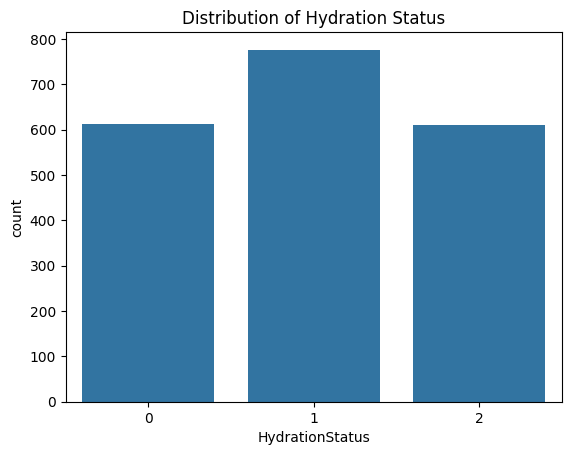

HydrationStatus
1    0.3880
0    0.3065
2    0.3055
Name: proportion, dtype: float64


In [7]:
sns.countplot(x='HydrationStatus', data=df)
plt.title('Distribution of Hydration Status')
plt.show()
print(df['HydrationStatus'].value_counts(normalize=True))

#Data Preprocessing

In [8]:
X = df.drop('HydrationStatus', axis=1)
Y = df['HydrationStatus']

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)

In [10]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {Y_train.shape}")
print(f"y_test shape: {Y_test.shape}")

X_train shape: (1500, 6)
X_test shape: (500, 6)
y_train shape: (1500,)
y_test shape: (500,)


# Feature Scaling

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_train_scaled_df.head()

,HeartRate,BodyTemperature,AmbientTemperature,ActivityLevel,FluidIntake_LastHour,TimeSinceLastDrink
0,-0.494698,-0.029454,-0.033608,-0.294308,1.720932,-0.969596
1,0.834607,0.468444,1.387886,-0.929211,-1.587332,-0.338901
2,-0.396809,-0.622320,-1.630250,-1.698443,-1.591868,1.106497
3,-0.348952,-0.041013,-1.506658,1.054379,-0.061274,-0.384718
4,0.656829,0.983953,-1.028793,0.670651,-0.064155,1.521192


# Feature Selection Insights
Correlation Analysis

In [13]:
train_df_for_corr = X_train.copy()
train_df_for_corr['HydrationStatus'] = Y_train

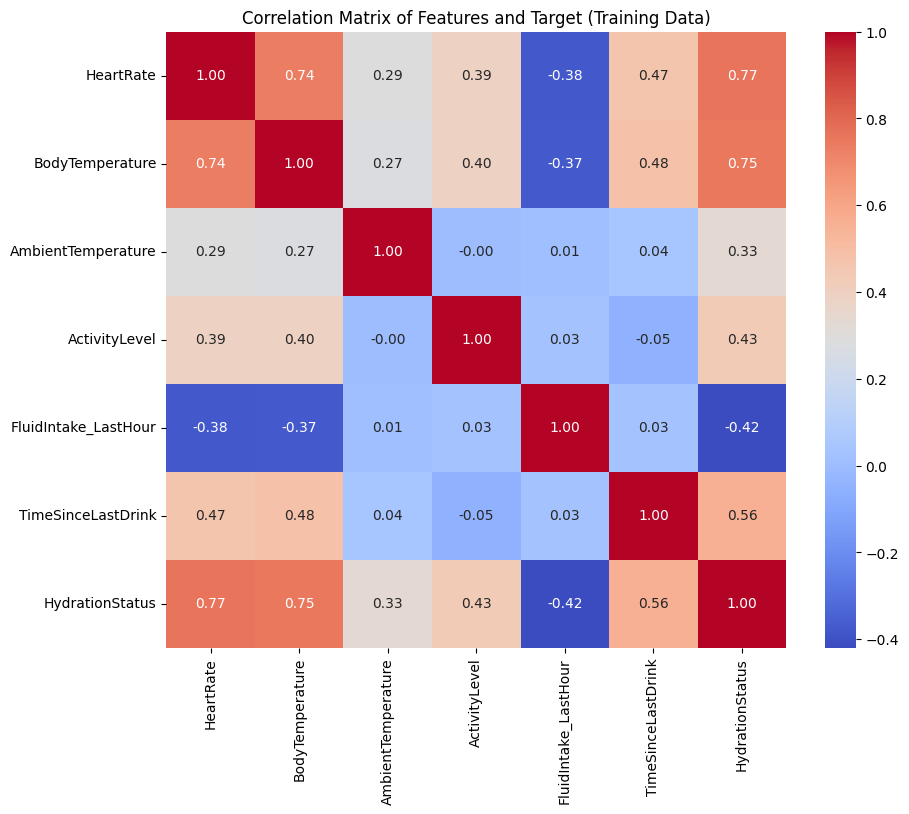

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_df_for_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features and Target (Training Data)')
plt.show()

# Observations from Correlation Matrix:
`TimeSinceLastDrink` and `ActivityLevel` show positive correlation with `HydrationStatus` (higher values -> more dehydrated).<br>
`FluidIntake_LastHour` shows a strong negative correlation (higher intake -> less dehydrated).<br>
`HeartRate` and `BodyTemperature` show positive correlation, as expected.<br>
`AmbientTemperature` also shows a positive correlation.<br>

These correlations align with our synthetic data generation logic.
For this prototype, we will use all features as they all seem relevant.

#Model Training: XGBoost Classifier

In [15]:
model = xgb.XGBClassifier(
    objective='multi:softmax', # Specifies multi-class classification
    num_class=3,             # Number of classes
    eval_metric='mlogloss',    # Evaluation metric for training
    use_label_encoder=False, # Suppress a warning, as y is already encoded
    random_state=42
)

In [16]:
model.fit(X_train_scaled, Y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:52:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

#Model Evaluation

In [17]:
Y_pred = model.predict(X_test_scaled)

# Accuracy

In [18]:
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.9140


# Classification Report

In [19]:
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred, target_names=['Well Hydrated', 'Mildly Dehydrated', 'Dehydrated']))


Classification Report:
                   precision    recall  f1-score   support

    Well Hydrated       0.93      0.94      0.94       153
Mildly Dehydrated       0.89      0.89      0.89       194
       Dehydrated       0.93      0.92      0.92       153

         accuracy                           0.91       500
        macro avg       0.92      0.92      0.92       500
     weighted avg       0.91      0.91      0.91       500



# Confusion Matrix

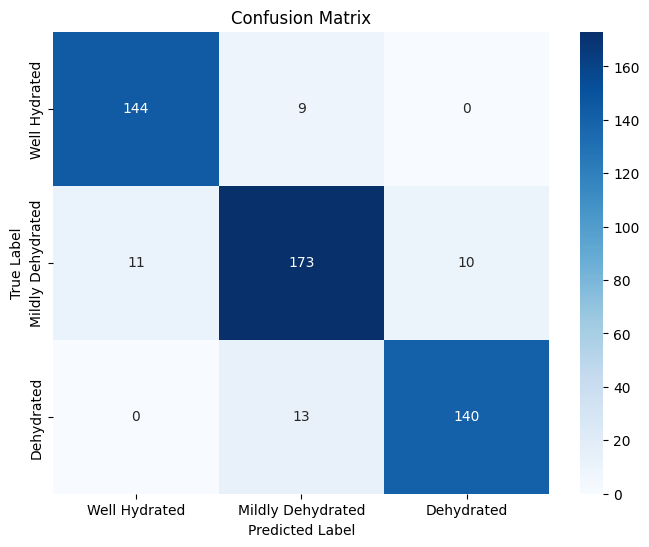

In [20]:
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Well Hydrated', 'Mildly Dehydrated', 'Dehydrated'],
            yticklabels=['Well Hydrated', 'Mildly Dehydrated', 'Dehydrated'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#Feature Importance

In [28]:
importances = model.feature_importances_
feature_names = X.columns

In [29]:
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)


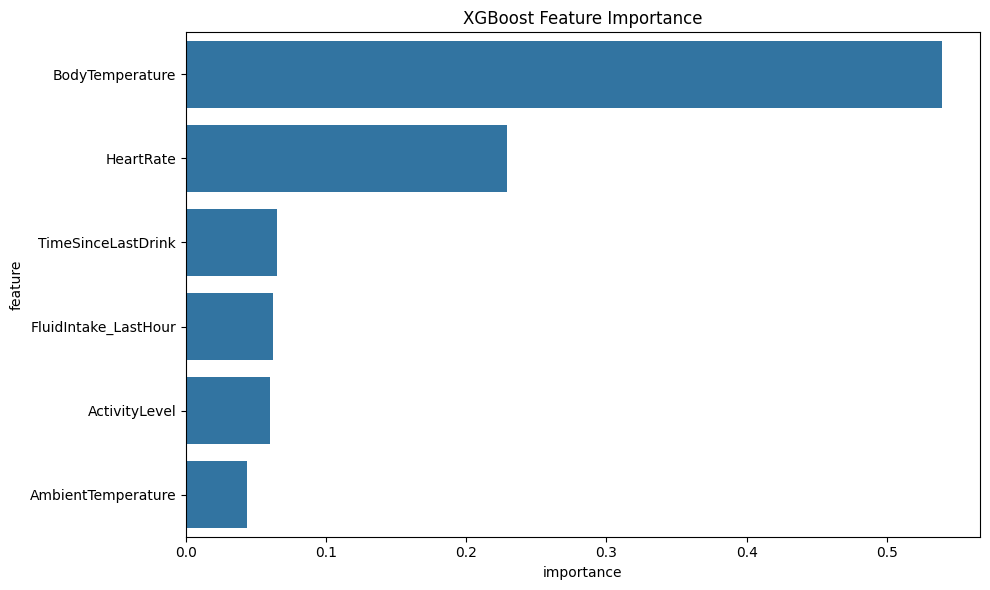

In [30]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# **Feature Importance Observations:**
The feature importances reflect the rules used in synthetic data generation. `FluidIntake_LastHour`, `TimeSinceLastDrink`, and `ActivityLevel` are typically the most dominant, which makes sense physiologically and based on our generation logic.<br>
This step is crucial. If some features had zero or very low importance, we could consider removing them to simplify the model (especially with real-world, noisy data).

# Hyperparameter Tuning with Optuna

In [31]:
def objective(trial):
  param = {
        'verbosity': 0, # Suppress XGBoost messages during tuning
        'objective': 'multi:softmax',
        'num_class': 3,
        'eval_metric': 'mlogloss', # Metric for XGBoost internal evaluation
        'use_label_encoder': False,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True), # L2 regularization
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),   # L1 regularization
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'eta': trial.suggest_float('eta', 1e-8, 0.3, log=True), # learning_rate
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True), # min_split_loss
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'random_state': 42
    }

  if param['booster'] == 'dart':
      param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
      param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
      param['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 1.0, log=True)
      param['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 1.0, log=True)
  model_opt = xgb.XGBClassifier(**param)
  cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3-5 folds is common
  cv_scores = []
  for train_idx, val_idx in cv.split(X_train_scaled, Y_train):
        X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        Y_train_fold, Y_val_fold = Y_train.iloc[train_idx], Y_train.iloc[val_idx] # Use .iloc for pandas Series

        model_opt.fit(X_train_fold, Y_train_fold,
                      eval_set=[(X_val_fold, Y_val_fold)],
                      verbose=False) # Suppress fitting messages for each fold
        preds = model_opt.predict(X_val_fold)
        accuracy = accuracy_score(Y_val_fold, preds)
        cv_scores.append(accuracy)

  return np.mean(cv_scores)

In [32]:
study = optuna.create_study(direction='maximize', study_name='xgb_hydration_tuning')

[I 2025-05-18 14:52:00,645] A new study created in memory with name: xgb_hydration_tuning


In [34]:
study.optimize(objective, n_trials=50)

[I 2025-05-18 15:06:03,393] Trial 19 finished with value: 0.8413333333333334 and parameters: {'booster': 'gbtree', 'lambda': 1.1155707686735529e-08, 'alpha': 2.1982177526836206e-05, 'subsample': 0.7629252815387583, 'colsample_bytree': 0.6894997182307698, 'max_depth': 6, 'min_child_weight': 7, 'eta': 2.6468799990190307e-06, 'gamma': 1.0990580135958807e-06, 'n_estimators': 500}. Best is trial 1 with value: 0.9133333333333334.
[I 2025-05-18 15:06:05,776] Trial 20 finished with value: 0.7886666666666667 and parameters: {'booster': 'gbtree', 'lambda': 0.015593214345219757, 'alpha': 0.0005165452790410678, 'subsample': 0.5244004353207606, 'colsample_bytree': 0.8026761429704483, 'max_depth': 4, 'min_child_weight': 8, 'eta': 2.3046852101984865e-08, 'gamma': 6.761300236596562e-08, 'n_estimators': 650}. Best is trial 1 with value: 0.9133333333333334.
[I 2025-05-18 15:06:08,858] Trial 21 finished with value: 0.9046666666666666 and parameters: {'booster': 'gbtree', 'lambda': 0.00035199607055375157,

In [35]:
print("Best trial:")
trial = study.best_trial
print(f"  Value (CV Accuracy): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")
best_params = trial.params

Best trial:
  Value (CV Accuracy): 0.9140
  Params: 
booster: gbtree
lambda: 0.028725727929975915
alpha: 3.1717506569826906e-07
subsample: 0.9352912870492481
colsample_bytree: 0.727751645829395
max_depth: 3
min_child_weight: 2
eta: 0.29808110362211376
gamma: 3.899343894412336e-05
n_estimators: 900


In [36]:
best_params['objective'] = 'multi:softmax'
best_params['num_class'] = 3
best_params['eval_metric'] = 'mlogloss'
best_params['use_label_encoder'] = False
best_params['random_state'] = 42

# Training Final Model with Best Hyperparameters

In [37]:
tuned_model = xgb.XGBClassifier(**best_params)

In [38]:
tuned_model.fit(X_train_scaled, Y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:41:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=3.1717506569826906e-07, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.727751645829395, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.29808110362211376, eval_metric='mlogloss',
              feature_types=None, gamma=3.899343894412336e-05, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=0.028725727929975915, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=900, ...)

# Evaluate the Tuned Model

In [39]:
Y_pred_tuned = tuned_model.predict(X_test_scaled)

# Accuracy

In [41]:
accuracy_tuned = accuracy_score(Y_test, Y_pred_tuned)
print(f"Tuned Model Accuracy: {accuracy_tuned:.4f}")

Tuned Model Accuracy: 0.9280


# Classification Report

In [43]:
print("\nTuned Model Classification Report:")
print(classification_report(Y_test, Y_pred_tuned, target_names=['Well Hydrated', 'Mildly Dehydrated', 'Dehydrated']))


Tuned Model Classification Report:
                   precision    recall  f1-score   support

    Well Hydrated       0.93      0.95      0.94       147
Mildly Dehydrated       0.91      0.91      0.91       192
       Dehydrated       0.96      0.93      0.94       161

         accuracy                           0.93       500
        macro avg       0.93      0.93      0.93       500
     weighted avg       0.93      0.93      0.93       500



# Confusion Matrix for the tuned model

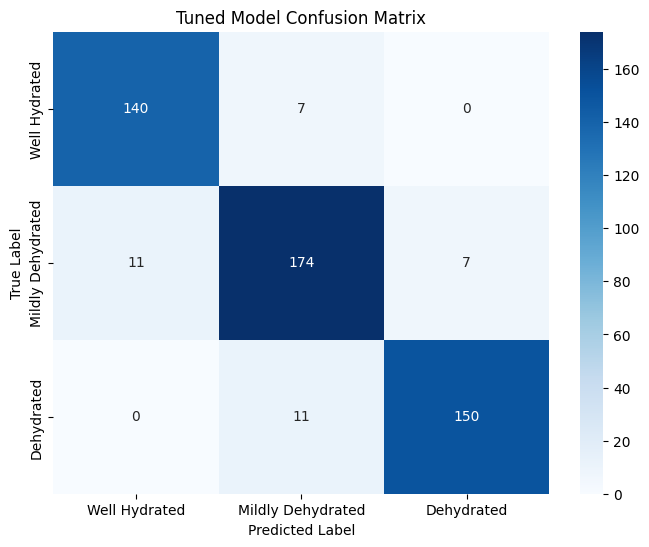

In [45]:
cm_tuned = confusion_matrix(Y_test, Y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Well Hydrated', 'Mildly Dehydrated', 'Dehydrated'],
            yticklabels=['Well Hydrated', 'Mildly Dehydrated', 'Dehydrated'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Tuned Model Confusion Matrix')
plt.show()

#Feature Importance

In [48]:
importances_tuned = tuned_model.feature_importances_
feature_names = X.columns
feature_importance_df_tuned = pd.DataFrame({'feature': feature_names, 'importance': importances_tuned})
feature_importance_df_tuned = feature_importance_df_tuned.sort_values(by='importance', ascending=False)

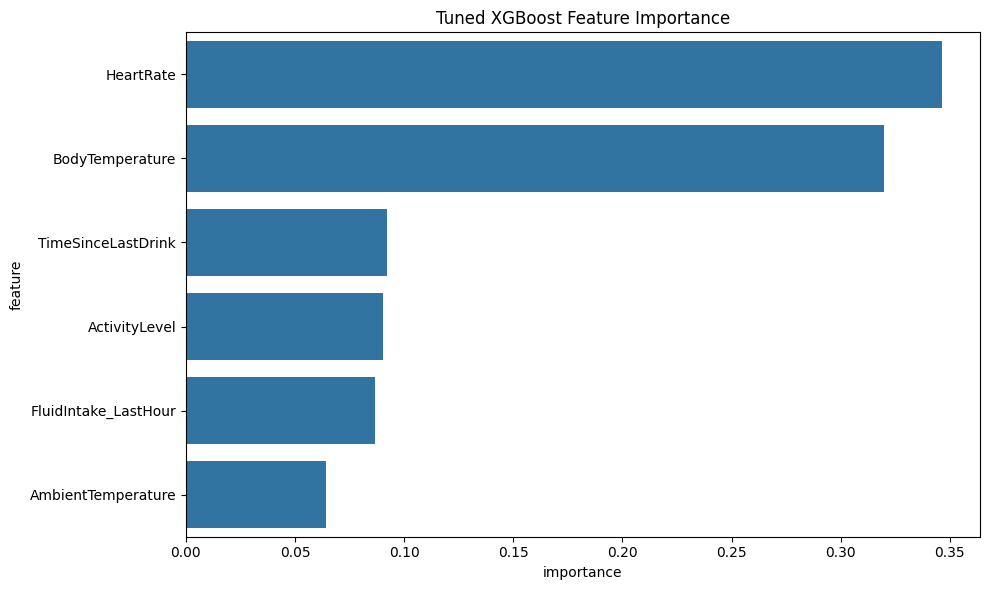

In [49]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df_tuned)
plt.title('Tuned XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Random Forest Model

In [51]:
def objective_rf(trial):
    """
    Define the objective function for Optuna with Random Forest.
    """
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)
    max_depth = trial.suggest_int('max_depth', 3, 20, log=True) # None can also be an option if you want to allow full growth
    min_samples_split = trial.suggest_int('min_samples_split', 2, 16)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 16)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None]) # None means max_features=n_features
    # criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']) # Can add if desired

    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        # criterion=criterion,
        random_state=42,
        n_jobs=-1 # Use all available cores
    )

    # Cross-validation (using the same scaled training data as XGBoost)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = []
    for train_idx, val_idx in cv.split(X_train_scaled, Y_train):
        X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_train_fold = Y_train.iloc[train_idx] # Use .iloc for pandas Series

        rf_model.fit(X_train_fold, y_train_fold)
        preds = rf_model.predict(X_val_fold)
        accuracy = accuracy_score(Y_train.iloc[val_idx], preds)
        cv_scores.append(accuracy)

    return np.mean(cv_scores)

In [52]:
study_rf = optuna.create_study(direction='maximize', study_name='rf_hydration_tuning')
study_rf.optimize(objective_rf, n_trials=50)

[I 2025-05-18 15:49:57,831] A new study created in memory with name: rf_hydration_tuning
[I 2025-05-18 15:49:58,577] Trial 0 finished with value: 0.7693333333333333 and parameters: {'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 0 with value: 0.7693333333333333.
[I 2025-05-18 15:50:03,457] Trial 1 finished with value: 0.86 and parameters: {'n_estimators': 450, 'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.86.
[I 2025-05-18 15:50:07,774] Trial 2 finished with value: 0.8526666666666666 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.86.
[I 2025-05-18 15:50:11,303] Trial 3 finished with value: 0.8446666666666666 and parameters: {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'log2'}

In [53]:
print("Best Random Forest trial:")
trial_rf = study_rf.best_trial
print(f"  Value (CV Accuracy): {trial_rf.value:.4f}")
print("  Params: ")
for key, value in trial_rf.params.items():
    print(f"{key}: {value}")

Best Random Forest trial:
  Value (CV Accuracy): 0.8753
  Params: 
n_estimators: 200
max_depth: 13
min_samples_split: 4
min_samples_leaf: 2
max_features: sqrt


In [54]:
best_params_rf = trial_rf.params
best_params_rf['random_state'] = 42
best_params_rf['n_jobs'] = -1

# Random Forest: Training Final Model with Best Hyperparameters

In [55]:
tuned_rf_model = RandomForestClassifier(**best_params_rf)
tuned_rf_model.fit(X_train_scaled, Y_train)

RandomForestClassifier(max_depth=13, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=200, n_jobs=-1, random_state=42)

# Predictions on the test set with the tuned Random Forest model

In [60]:
Y_pred_rf_tuned = tuned_rf_model.predict(X_test_scaled)

# Accuracy

In [61]:
accuracy_rf_tuned = accuracy_score(Y_test, Y_pred_rf_tuned)
print(f"Tuned Random Forest Model Accuracy: {accuracy_rf_tuned:.4f}")

Tuned Random Forest Model Accuracy: 0.8660


# Classification Report

In [63]:
print("\nTuned Random Forest Model Classification Report:")
print(classification_report(Y_test, Y_pred_rf_tuned, target_names=['Well Hydrated', 'Mildly Dehydrated', 'Dehydrated']))


Tuned Random Forest Model Classification Report:
                   precision    recall  f1-score   support

    Well Hydrated       0.86      0.90      0.88       147
Mildly Dehydrated       0.81      0.85      0.83       192
       Dehydrated       0.95      0.84      0.89       161

         accuracy                           0.87       500
        macro avg       0.87      0.87      0.87       500
     weighted avg       0.87      0.87      0.87       500



# Confusion Matrix for the tuned Random Forest model

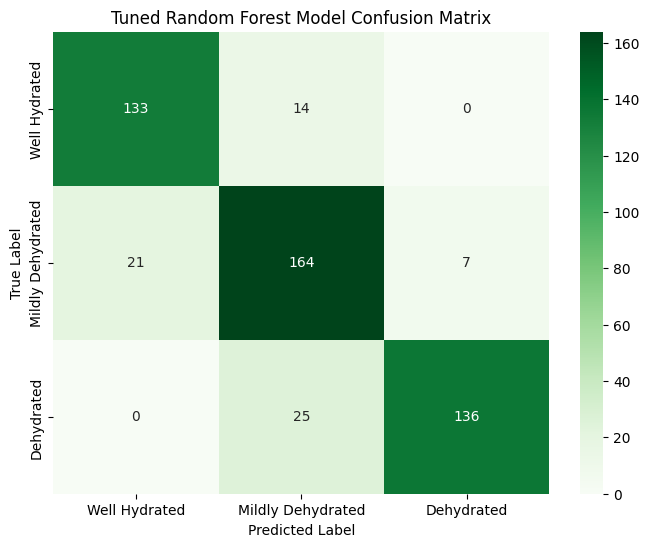

In [69]:
cm_rf_tuned = confusion_matrix(Y_test, Y_pred_rf_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Well Hydrated', 'Mildly Dehydrated', 'Dehydrated'],
            yticklabels=['Well Hydrated', 'Mildly Dehydrated', 'Dehydrated'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Tuned Random Forest Model Confusion Matrix')
plt.show()

#Random Forest: Feature Importance

In [65]:
importances_rf = tuned_rf_model.feature_importances_
feature_names_rf = X.columns # Same as X_train.columns

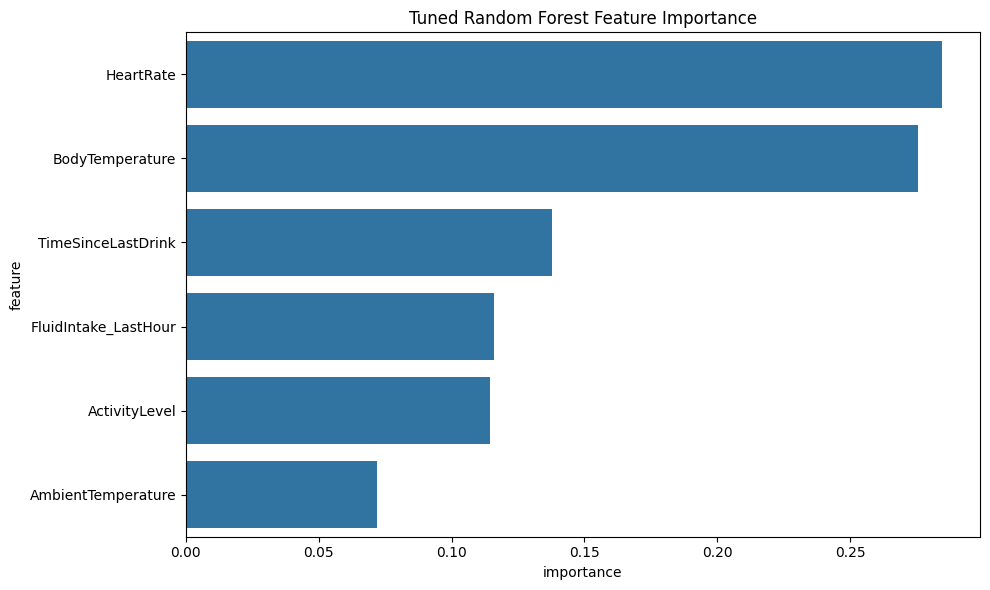

In [67]:
feature_importance_df_rf = pd.DataFrame({'feature': feature_names_rf, 'importance': importances_rf})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df_rf)
plt.title('Tuned Random Forest Feature Importance')
plt.tight_layout()
plt.show()